This page details the NeutralizationBench.py module. 

This is use to simulate reactions between any given number of antigens and antibodies. 
It works on the assumption that a given antibody attaches to only a single site
on the virus.

Assume we have n antigens and m antibodies. We denote antigens by V_i and antibodies 
as Ab_j where i and j are the indices.  Let I denote any selection of indices from 
1,..,m then V_jAb_I denotes the complex formed by virus j and antibodies given by 
the indices I attached. If I=empty then this means just virus j.

We denote the reaction of attachment of antibody i to complex V_jAb_I as:

	[V_jAb_I] + [Ab_i] <=> [V_jAb_I2]

where I2 = I union {i}. In the case I=empty then we just have the usual equation

	[V_j] + [Ab_i] <=> [V_jAb_i]


This reaction is regulated by two rates the association rate (or k(j,I,i)
and the dissociation rate b(j,I,i). k(j,I,i) for instance represents the rate 
of attachment of antibody i to the complex formed by virus j + antibodies I.
As another example k(j,empty,i) would be the rate of attachment of antibody i 
to the virus j (since I=empty means no antibodies are attached to virus).
In such a case, for simplicity we will shows these rates by k(j,i) and drop the empty.
Similarly for b.

If different antibodies dont interfere with each other then k(j,I,i)=k(j,i) 
for any I.

The main inputs to this machinery are therefore the the rates k(j,I,i) and b(j,I,i).
We can make some simplifying assumptions in determination of these rates 
as k(j,I,i) as it stands out could be alot of rates since I is any combination 
of antigen indices in any number.

To start with for simpilicity one can assume b(j,I,i) = b(j,i), that is there is no interference
for dissociation rate. We also assume association rates can be represented as:

	k(j,I,i)=k(j,i)*interference(j,I,i)
	
This means that k(j,I,i) equals to original rate of attachment of antigen i to
virus j times an interference term due to antibodies I being bound to virus j.
	
Moreover if I=(i1,...,in) then 

	interference(j,I,i)= interference(j,i1,i)*interference(j,i2,i)*...*interference(j,in,i)
	
This is to say interference due to different antibodies being bound to the virus j
are independent of each other. If all interference rates are 1 then it means that antibodies
dont interefere with each other, if they are all 0 then binding of one antibody
completely prevents the others.	

With these simplifications the rates one needs to determine are as follows:

Given a virus j and antibodies i1,...,in, you have to determine the association 
rates k(j,i), dissociation rates b(j,i) and the intereference between each 
antibody interference(j,k1,k2) where k1,k2 = i1,...,in. 

Various literature suggest that association rates of antibodies against hemaglutinnin (in various
different setups) range between 1e5 to 1e6 1/Ms where M is molars ad s is seconds and dissociation rates vary between 1e-5 to 1e-3 1/s ([1] Figure 4, [2] Figure 3, [3], Table 1). Binding affinity which the ratio of association and dissociation rates is between 1e8 to 1e10 1/M ([2] Figure 3). 

Finally there is the assay_sensitivity parameter for each antibody. If assay_sensitivity = 1 for 
antibody i, then all the complexes  V_jAb_i is considered completely inactive. If it is 0.9, 
then 0.1 are still active. For multiple cases V_jAb_{i1,i2,..} then the percent inactive is the
maximum among the sensitivity parameters for Ab_{i1},...,Ab_{i2}. This parameter can be used to 
test things like assays only specific to NA or HA or both etc. If this parameter is not given 
as input, it is assume that all sensitivities are 1.

There other inputs required such as the initial concentration of antibody binding sites
and initial concentration of antibodies. A rough estimate for the latter was determined
by using the FRA experiments recently done in Erasmus. One also needs to input which serial
dilutions of sera are used for neutralization and the neutralization time. See the example
code below.

[1] 'Sequential Seasonal H1N1 Influenza Virus Infections Protect Ferrets
against Novel 2009 H1N1 Influenza Virus', Carter, D.M. et al.

[2] 'The Breadth of Cross Sub-Type Neutralisation Activity of
a Single Domain Antibody to Influenza Hemagglutinin
Can Be Increased by Antibody Valency', Hufton, S.E. et al. 

[3] 'Heterosubtypic Antibodies to Influenza A Virus Have Limited Activity against Cell-Bound Virus but Are Not Impaired by Strain-Specific Serum Antibodies', Wyrzucki A. et al.

We start by given an example of what kind of equations this package generates. Consider 
a system with 1 antigen and 3 antibodies. We will use the _systemOfEquations function
with print_equations=True. This function is normally called from titrateAntigensAgainstSera
which what the user will be using to get the neutralization and titer curves (you can also
supply print_equations option to this function). For the purposes of this demonstration,
we set association and dissociation constants to be 2 and 1 respectively so their position
in the equatios are evident.

In [2]:
import sys
import numpy as np
from NeutralizationBench import _systemOfEquations,titrateAntigensAgainstSera, outputScatterPlot, outputTiterCurvePlot

number_of_antigens = 1
number_of_antibodies = 2

association_rates = 2 * np.ones((number_of_antigens, number_of_antibodies))
dissociation_rates = np.ones((number_of_antigens, number_of_antibodies))
interference_matrix = np.ones((number_of_antigens, number_of_antibodies, number_of_antibodies))    

ode, variables, _ = _systemOfEquations(
    number_of_antigens, number_of_antibodies, association_rates, dissociation_rates,
    interference_matrix, print_equations=True)   


System of equations is:

0- d[V0]/dt=-2.0*Ab_0*V0 - 2.0*Ab_1*V0 + 1.0*V0Ab_0 + 1.0*V0Ab_1

1- d[Ab_0]/dt=-2.0*Ab_0*V0 - 2.0*Ab_0*V0Ab_1 + 1.0*V0Ab_0 + 1.0*V0Ab_0_1

2- d[Ab_1]/dt=-2.0*Ab_1*V0 - 2.0*Ab_1*V0Ab_0 + 1.0*V0Ab_0_1 + 1.0*V0Ab_1

3- d[V0Ab_0]/dt=2.0*Ab_0*V0 - 2.0*Ab_1*V0Ab_0 - 1.0*V0Ab_0 + 1.0*V0Ab_0_1

4- d[V0Ab_1]/dt=-2.0*Ab_0*V0Ab_1 + 2.0*Ab_1*V0 + 1.0*V0Ab_0_1 - 1.0*V0Ab_1

5- d[V0Ab_0_1]/dt=2.0*Ab_0*V0Ab_1 + 2.0*Ab_1*V0Ab_0 - 2.0*V0Ab_0_1



Now we test the percentage law which says that if antibodies in sera is much more
abundant compared to virus, then a change in PFU does not change the titer curves.
We obtain the titer curves for both excess and non-excess sera and plot the titer curves.

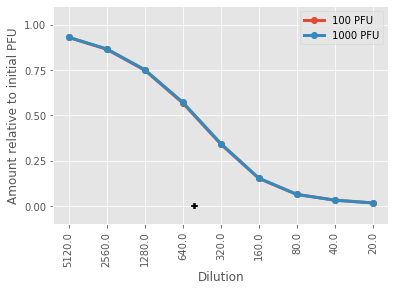

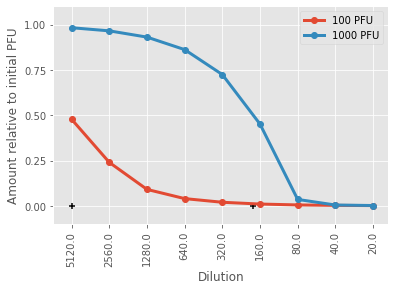

In [16]:
#testing percenage law which says when serum is in excess compared to viruses
#change in PFU does not change titers

number_of_antigens = 1
number_of_antibodies = 1
M = 6e23
vratio = 50
nspike = 450
ratio = vratio * nspike
total_volume = 1e-4
total_antibody = 600 * 5e9


#we first try the case of excess antibodies
#in which we do not observe shift of titer curves with respect to PFU

association_rates = np.ones((number_of_antigens, number_of_antibodies)) * 2.5e6 / M
dissociation_rates = 1e-4 ** np.ones((number_of_antigens, number_of_antibodies))
interference_matrix = np.ones((number_of_antigens, number_of_antibodies, number_of_antibodies))

total_PFUs = [100, 10000]

ax = None
fig = None
for total_PFU in total_PFUs:  
    init_vals = [total_PFU * ratio / total_volume , total_antibody / total_volume]
    
    
    measurement_time = 3600
    dilutions=1/np.array([5120,2560,1280,640,320,160,80,40,20])
    
    
    y, log_titer, titer, _ = titrateAntigensAgainstSera(
        init_vals, dilutions, number_of_antigens, number_of_antibodies, measurement_time,
        association_rates, dissociation_rates, interference_matrix)   
    
    ax, fig = outputTiterCurvePlot(y, log_titer, number_of_antigens, dilutions, fig=fig, ax=ax)

    ax.set_ylabel('Amount relative to initial PFU')
    ax.set_xlabel('Dilution')
ax.legend(['100 PFU', '1000 PFU'])    
    
#then we try the case of not-excess antibodies
#in which we do not observe shift of titer curves with respect to PFU    
    
association_rates = np.ones((number_of_antigens, number_of_antibodies)) * 5e9 / M
total_antibody = 4 * 5e9

dissociation_rates = 1e-4 * np.ones((number_of_antigens, number_of_antibodies))
total_PFUs = [100, 10000]

ax = None
fig = None
for total_PFU in total_PFUs:  
    init_vals = [total_PFU * ratio / total_volume, total_antibody / total_volume]
    
    
    measurement_time = 3600
    dilutions = 1 / np.array([5120,2560,1280,640,320,160,80,40,20])
    
    
    y, log_titer, titer, _=titrateAntigensAgainstSera(
        init_vals, dilutions, number_of_antigens, number_of_antibodies, measurement_time,
        association_rates, dissociation_rates, interference_matrix)  
    
    ax, fig = outputTiterCurvePlot(y, log_titer, number_of_antigens, dilutions, fig=fig, ax=ax)

    ax.set_ylabel('Amount relative to initial PFU')
    ax.set_xlabel('Dilution')    
ax.legend(['100 PFU', '1000 PFU']);    


We now test how titers are mixed. Assume we have to antibody solutions with concentrations c1 and c2.

In case one, we first get the titer curves for two antibodies individually and then for sera containing them
mixed in 0.5*c1 and 0.5*c2 concentrations. This corresponds to the case of titrating a virus agains two antibody
solutions first and then making a new solution by taking half of each of the initial solution.

In case two, we again have two antibodoes but we mix them by adding them together (i.e mixed together in 
concentrations c1 and c2). This case corresponds to using an assay that measures HA and NA antibody titers
seperately and then together.
                                                                                  


Titers are respectively [396], [1297], [858].
Arithmetic mean of first two titers is 846.5.


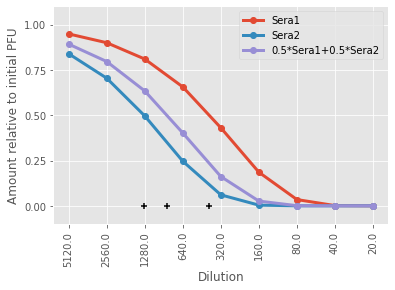

In [15]:
#testing individual sera vs combined sera

#sera1
number_of_antigens = 1
number_of_antibodies = 1


association_rates = np.ones((number_of_antigens, number_of_antibodies)) * 1.5e6 / M
dissociation_rates = 1e-8 ** np.ones((number_of_antigens, number_of_antibodies))
total_antibody = 600 * 5e9
interference_matrix = np.ones((number_of_antigens, number_of_antibodies, number_of_antibodies))
total_PFU = 1000

init_vals = [total_PFU * ratio / total_volume, total_antibody / total_volume]


ax1 = None
fig1 = None
ax2 = None
fig2 = None

y1, log_titer1, titer1, _=titrateAntigensAgainstSera(
        init_vals, dilutions, number_of_antigens, number_of_antibodies, measurement_time,
        association_rates, dissociation_rates, interference_matrix)  

ax1, fig1 = outputTiterCurvePlot(y1, log_titer1, number_of_antigens, dilutions, fig=fig1, ax=ax1)

ax1.set_ylabel('Amount relative to initial PFU')
ax1.set_xlabel('Dilution')

#sera 2
association_rates = np.ones((number_of_antigens, number_of_antibodies)) * 5e6 / M

y2, log_titer2, titer2, _=titrateAntigensAgainstSera(
        init_vals, dilutions, number_of_antigens, number_of_antibodies, measurement_time,
        association_rates, dissociation_rates, interference_matrix)   

ax1, fig1 = outputTiterCurvePlot(y2, log_titer2, number_of_antigens, dilutions, fig=fig1, ax=ax1)
ax1.set_ylabel('Amount relative to initial PFU')
ax1.set_xlabel('Dilution')


#combined 0.5sera1 + 0.5sera2
number_of_antigens = 1
number_of_antibodies = 2

association_rates = np.ones((number_of_antigens, number_of_antibodies)) * 1.5e6 / M
association_rates[0,1] = 5e6 / M
dissociation_rates = 1e-8 ** np.ones((number_of_antigens, number_of_antibodies))
total_antibody = 600 * 5e9
interference_matrix = np.ones((number_of_antigens, number_of_antibodies, number_of_antibodies))
total_PFU = 1000

init_vals = [total_PFU * ratio / total_volume, 0.5 * total_antibody / total_volume,
             0.5 * total_antibody / total_volume]


y3, log_titer3, titer3, _=titrateAntigensAgainstSera(
        init_vals, dilutions, number_of_antigens, number_of_antibodies, measurement_time,
        association_rates, dissociation_rates, interference_matrix)    

ax1, fig1 = outputTiterCurvePlot(y3, log_titer3, number_of_antigens, dilutions, fig=fig1, ax=ax1)

ax1.legend(['Sera1', 'Sera2', '0.5*Sera1+0.5*Sera2'])

print('Titers are respectively {}, {}, {}.'.format(titer1,titer2,titer3))
print('Arithmetic mean of first two titers is {}.'.format((titer1[0]+titer2[0]) * 0.5))



We see that in the first case, the mixed titer is somewhere between the first two. The value is quite close to arithmetic mean. More tests will be performed to see if this is true for more cases (with different mixing proportions).

Now below we test assay_sensitivity. In this case serum mixture remains the same between calls but assay_sensitivity parameters are [1,0] for the first case, [0,1] for the second, [1,1] for the last
which means in the first case only first antibodies inactivate, in the second only second ones inactivate and in the last both of them do (it is anologous to doing an HI assay NA inhibition assay and FRA assay).

Titers respectively are [396], [1297], [1716]
Sum of titers 1 and 2 is 1693

Ab1 + Ab2 titer curve values 
[7.9620e-01 6.3390e-01 4.0175e-01 1.6131e-01 2.6000e-02 6.8000e-04
 0.0000e+00 0.0000e+00 0.0000e+00]
Gregs mixing titer curve values 
[7.9620e-01 6.3390e-01 4.0174e-01 1.6129e-01 2.5970e-02 6.7000e-04
 0.0000e+00 0.0000e+00 0.0000e+00]


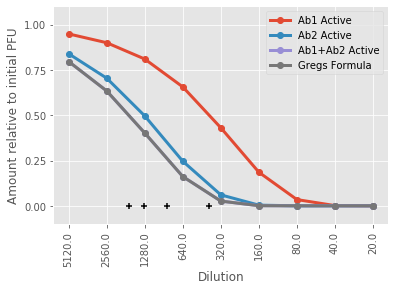

In [13]:
#testing assay_sensitivity
ax1 = None
fig1 = None
ax2 = None
fig2 = None

#sera1
number_of_antigens = 1
number_of_antibodies = 2

association_rates = np.ones((number_of_antigens, number_of_antibodies)) * 1.5e6 / M
association_rates[0,1] = 5e6 / M
dissociation_rates = 1e-8 ** np.ones((number_of_antigens, number_of_antibodies))
total_antibody = 600 * 5e9
interference_matrix = np.ones((number_of_antigens, number_of_antibodies, number_of_antibodies))
total_PFU = 1000

init_vals = [total_PFU * ratio / total_volume, total_antibody / total_volume, total_antibody / total_volume]

assay_sensitivity=np.array([1,0])

y1, log_titer1, titer1, _=titrateAntigensAgainstSera(
        init_vals, dilutions, number_of_antigens, number_of_antibodies, measurement_time,
        association_rates, dissociation_rates, interference_matrix, assay_sensitivity=assay_sensitivity)   

ax1, fig1 = outputTiterCurvePlot(y1, log_titer1, number_of_antigens, dilutions, fig=fig1, ax=ax1)

assay_sensitivity=np.array([0,1])

y2, log_titer2, titer2, _=titrateAntigensAgainstSera(
        init_vals, dilutions, number_of_antigens, number_of_antibodies, measurement_time,
        association_rates, dissociation_rates, interference_matrix, assay_sensitivity=assay_sensitivity)    

ax1, fig1 = outputTiterCurvePlot(y2, log_titer2, number_of_antigens, dilutions, fig=fig1, ax=ax1)

assay_sensitivity=np.array([1,1])

y3, log_titer3, titer3, _=titrateAntigensAgainstSera(
        init_vals, dilutions, number_of_antigens, number_of_antibodies, measurement_time,
        association_rates, dissociation_rates, interference_matrix, assay_sensitivity=assay_sensitivity)  

ax1, fig1 = outputTiterCurvePlot(y3, log_titer3, number_of_antigens, dilutions, fig=fig1, ax=ax1)

P1 = 1 - y1
P2 = 1 - y2
P3 = P1 + P2 - P1 * P2

ax1, fig1 = outputTiterCurvePlot(1 - P3, log_titer, number_of_antigens, dilutions, fig=fig1, ax=ax1)

ax1.set_ylabel('Amount relative to initial PFU')
ax1.set_xlabel('Dilution')
ax1.legend(['Ab1 Active','Ab2 Active','Ab1+Ab2 Active','Gregs Formula'])

print('Titers respectively are {}, {}, {}'.format(titer1,titer2,titer3))
print('Sum of titers 1 and 2 is {}\n'.format(titer1[0]+titer2[0]))

print('Ab1 + Ab2 titer curve values ')
print(np.round(y3.flatten(),5))

print('Gregs mixing titer curve values ')
print(np.round(1-P3.flatten(),5))


As expected, in the case both antibodies are active, the titer is higher then both. We also compare it with Greg's Formula in which the titer curves T1, T2 mix as T3 = 1 - ( (1-T1) + (1-T2) + (1-T1) * (1-T2) ). Note that here 1 - T1 and 1 - T2 are probabilities of inactivation so if we denote them as P1 , P2 then P3 = P1 + P2 - P1 * P2. Also note in Greg's formula sigmoid functions are used instead of tuter curves since the working assumption is that you only have titers and the sigmoid curves are approximations to the titer curves. Here instead of the sigmoids I used the titer curves T1 and T2 to construct P1 and P2 directly instead of approximating them by sigmoids.

Greg's formula coincides exactly with the simulated titers. Infact the values seem to match exactly upto numerical errors. More tests will be performed later to see whether if this is just coincidence or atleast a parameter dependent issue. My feeling is however that Gregs formula is an analytical solution to how the titers should be mixed (in this particular situation) so understandbly matches well with its numerical solution obtained via the ODEs.
